In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchinfo import summary



In [2]:
def adjust_label(y):
    return (y - 1) % 10  # Convert labels from 1-10 to 0-9

class DepthwiseSeparableBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, residual=False):
        """
        A depthwise separable convolution block.
          - in_channels: number of input channels.
          - out_channels: number of output channels.
          - stride: stride for depthwise conv.
          - residual: if True and shapes match, add residual connection.
        """
        super(DepthwiseSeparableBlock, self).__init__()
        self.residual = residual and (in_channels == out_channels) and (stride == 1)
        # Depthwise convolution: each input channel is convolved separately.
        self.dw_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                 stride=stride, padding=1, groups=in_channels, bias=False)
        self.dw_bn = nn.BatchNorm2d(in_channels)
        # Pointwise convolution: combine channels.
        self.pw_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pw_bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.dw_conv(x)
        out = self.dw_bn(out)
        out = self.relu(out)
        out = self.pw_conv(out)
        out = self.pw_bn(out)
        if self.residual:
            out = out + x
        out = self.relu(out)
        return out

class MinimalSVHNNet(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        
        super(MinimalSVHNNet, self).__init__()
        
        channels = [int(c * width_mult) for c in [16, 32, 64]]
        
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.relu = nn.ReLU(inplace=True)
        
        self.block1 = DepthwiseSeparableBlock(channels[0], channels[1], stride=2, residual=False)
       
        self.block2 = DepthwiseSeparableBlock(channels[1], channels[1], stride=1, residual=True)
        self.block3 = DepthwiseSeparableBlock(channels[1], channels[2], stride=2, residual=False)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(channels[2], num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        
        out = self.global_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Step per batch
            
            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = 100. * correct / total
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_minimal_model.pth')
        
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    elapsed = time.time() - start_time
    print(f"Training complete in {elapsed/60:.2f} minutes")
    return history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss /= total
    test_acc = 100. * correct / total
    return test_loss, test_acc



In [7]:
if __name__ == '__main__':
    # For systems using the spawn start method (e.g. macOS)
    import torch.multiprocessing as mp
    mp.set_start_method('spawn', force=True)
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print("Using device:", device)
    
    # Data augmentation and preprocessing
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4377, 0.4438, 0.4728],
                             std=[0.1980, 0.2010, 0.1970])
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4377, 0.4438, 0.4728],
                             std=[0.1980, 0.2010, 0.1970])
    ])
    
    train_full = torchvision.datasets.SVHN(root='./data', split='train', download=True,
                                             transform=train_transform, target_transform=adjust_label)
    extra = torchvision.datasets.SVHN(root='./data', split='extra', download=True,
                                        transform=train_transform, target_transform=adjust_label)
    test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True,
                                               transform=test_transform, target_transform=adjust_label)
    
    # Combine train and extra, then split into train/validation sets
    train_val_set = ConcatDataset([train_full, extra])
    total = len(train_val_set)
    train_size = int(0.7 * total)
    val_size = total - train_size
    train_dataset, val_dataset = random_split(train_val_set, [train_size, val_size],
                                              generator=torch.Generator().manual_seed(42))
    
    batch_size = 128
    num_workers = 0
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Initialize the minimal model
    # Using width_mult=0.75 gives channels scaled down from [16, 32, 64]
    width_mult = 0.75
    model = MinimalSVHNNet(num_classes=10, width_mult=width_mult).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Setup optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Instead of specifying steps_per_epoch and epochs, we calculate total_steps for 50 epochs.
    total_steps = 50 * len(train_loader)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                              total_steps=total_steps)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Train the model for 50 epochs
    # history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50)
    



Using device: mps
Total parameters: 3,706


In [12]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_minimal_model.pth', map_location=torch.device('cpu')))

test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

summary(model, input_size=(1, 3, 32, 32))

Final Test Loss: 0.9027, Test Accuracy: 87.04%


Layer (type:depth-idx)                   Output Shape              Param #
MinimalSVHNNet                           [1, 10]                   --
├─Conv2d: 1-1                            [1, 12, 32, 32]           324
├─BatchNorm2d: 1-2                       [1, 12, 32, 32]           24
├─ReLU: 1-3                              [1, 12, 32, 32]           --
├─DepthwiseSeparableBlock: 1-4           [1, 24, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 12, 16, 16]           108
│    └─BatchNorm2d: 2-2                  [1, 12, 16, 16]           24
│    └─ReLU: 2-3                         [1, 12, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 24, 16, 16]           288
│    └─BatchNorm2d: 2-5                  [1, 24, 16, 16]           48
│    └─ReLU: 2-6                         [1, 24, 16, 16]           --
├─DepthwiseSeparableBlock: 1-5           [1, 24, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 24, 16, 16]           216
│    └─Batc

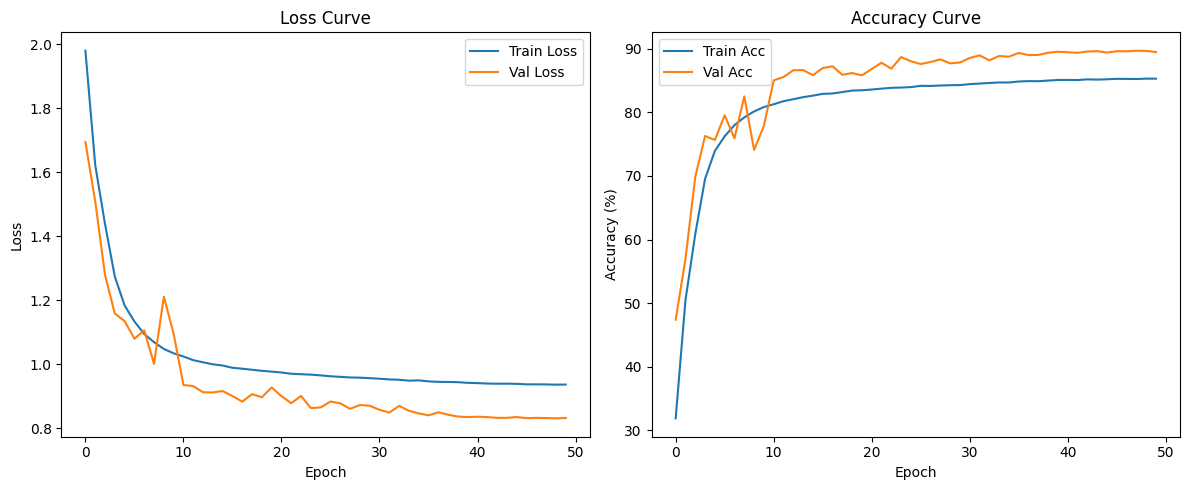

In [13]:
import matplotlib.pyplot as plt

# Store your training/validation statistics in a dictionary as this was run on ccr.
history = {
    'train_loss': [
        1.9805, 1.6234, 1.4385, 1.2743, 1.1841, 1.1341, 1.0951, 1.0695, 1.0483, 1.0347,
        1.0247, 1.0132, 1.0066, 1.0003, 0.9965, 0.9894, 0.9866, 0.9832, 0.9799, 0.9774,
        0.9747, 0.9708, 0.9693, 0.9680, 0.9657, 0.9629, 0.9611, 0.9592, 0.9585, 0.9570,
        0.9552, 0.9530, 0.9520, 0.9491, 0.9501, 0.9470, 0.9455, 0.9451, 0.9444, 0.9424,
        0.9415, 0.9402, 0.9396, 0.9398, 0.9392, 0.9377, 0.9377, 0.9374, 0.9367, 0.9370
    ],
    'train_acc': [
        31.91, 50.49, 60.87, 69.55, 73.93, 76.23, 77.99, 79.20, 80.14, 80.83,
        81.27, 81.75, 82.06, 82.38, 82.62, 82.90, 82.96, 83.18, 83.42, 83.46,
        83.58, 83.72, 83.85, 83.89, 83.96, 84.16, 84.14, 84.21, 84.26, 84.28,
        84.43, 84.52, 84.61, 84.69, 84.69, 84.84, 84.90, 84.89, 84.99, 85.08,
        85.09, 85.07, 85.18, 85.14, 85.19, 85.26, 85.25, 85.23, 85.29, 85.29
    ],
    'val_loss': [
        1.6949, 1.5097, 1.2793, 1.1589, 1.1353, 1.0801, 1.1066, 1.0016, 1.2115, 1.0958,
        0.9357, 0.9322, 0.9129, 0.9124, 0.9167, 0.9010, 0.8836, 0.9070, 0.8974, 0.9279,
        0.9006, 0.8787, 0.9013, 0.8635, 0.8655, 0.8840, 0.8784, 0.8611, 0.8730, 0.8708,
        0.8582, 0.8494, 0.8703, 0.8551, 0.8468, 0.8408, 0.8504, 0.8428, 0.8371, 0.8353,
        0.8365, 0.8352, 0.8329, 0.8330, 0.8355, 0.8319, 0.8329, 0.8323, 0.8314, 0.8324
    ],
    'val_acc': [
        47.41, 56.95, 69.87, 76.28, 75.65, 79.53, 75.91, 82.51, 74.09, 77.86,
        85.01, 85.55, 86.60, 86.64, 85.84, 86.95, 87.23, 85.90, 86.17, 85.81,
        86.81, 87.79, 86.85, 88.68, 88.02, 87.59, 87.91, 88.31, 87.69, 87.83,
        88.54, 88.95, 88.17, 88.85, 88.74, 89.33, 88.99, 89.02, 89.36, 89.52,
        89.44, 89.35, 89.56, 89.61, 89.39, 89.60, 89.59, 89.68, 89.65, 89.47
    ]
}

# Create the figure and subplots
plt.figure(figsize=(12, 5))

# --- Loss subplot ---
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# --- Accuracy subplot ---
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
import numpy as np
from sklearn.metrics import classification_report

def print_classification_report(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate predictions and true labels from all batches
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Print the classification report
    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(10)])
    print(report)

# Make sure to load the model onto the correct device:
model.load_state_dict(torch.load('best_minimal_model.pth', map_location=device))
model.to(device)

# Now, print the classification report:
print_classification_report(model, test_loader, device)


              precision    recall  f1-score   support

     Class 0       0.91      0.87      0.89      5099
     Class 1       0.88      0.92      0.90      4149
     Class 2       0.82      0.85      0.84      2882
     Class 3       0.88      0.91      0.90      2523
     Class 4       0.86      0.88      0.87      2384
     Class 5       0.84      0.86      0.85      1977
     Class 6       0.91      0.89      0.90      2019
     Class 7       0.85      0.73      0.79      1660
     Class 8       0.83      0.83      0.83      1595
     Class 9       0.85      0.88      0.87      1744

    accuracy                           0.87     26032
   macro avg       0.86      0.86      0.86     26032
weighted avg       0.87      0.87      0.87     26032

